In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
hits_train = pd.read_csv("train.csv", index_col='global_id')
hits_train.head()

,event_id,wire_id,energy_deposit,relative_time,label
global_id,,,,,
0,0,0,0.000000e+00,0.000000,0
1,0,1,0.000000e+00,0.000000,0
2,0,2,0.000000e+00,0.000000,0
3,0,3,0.000000e+00,0.000000,0
4,0,4,1.178108e-08,22.224176,0


In [4]:
hits_test = pd.read_csv("test.csv", index_col='global_id')
hits_test.head()

,event_id,wire_id,energy_deposit,relative_time,label
global_id,,,,,
761940,170,0,0.000000e+00,0.00000,0
761941,170,1,0.000000e+00,0.00000,0
761942,170,2,0.000000e+00,0.00000,0
761943,170,3,0.000000e+00,0.00000,0
761944,170,4,5.038868e-07,906.08197,0


# Naive manual analysis
Obviously a not-so-good algorithm, used primaraly for illustrating IPython

First, check whether a a signal wire can have energy_deposit = 0

In [5]:
set(hits_train.loc[(hits_train.energy_deposit == 0)].label)

{0.0}

In [6]:
candidates = hits_train.loc[(hits_train.energy_deposit > 0)]

Try plotting time vs. energy vs. label. It's too big, so we'll take a sample. 

In [7]:
plot_sample_indices = np.random.choice(np.arange(len(candidates)), size=50000)
hits_to_plot = candidates.iloc[plot_sample_indices]

/opt/conda/envs/open-ml/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


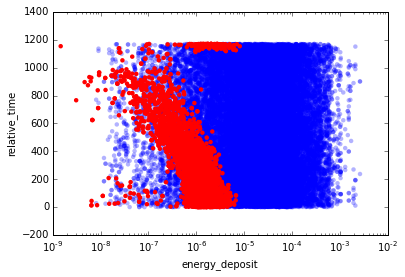

In [8]:
fig, ax = plt.subplots()
signal_hits = hits_to_plot.loc[(hits_to_plot.label == 1)]
noise_hits = hits_to_plot.loc[(hits_to_plot.label == 0)]
ax.scatter(noise_hits.energy_deposit, noise_hits.relative_time, c='b', edgecolors='none', alpha=0.3)
ax.scatter(signal_hits.energy_deposit, signal_hits.relative_time, c='r', edgecolors='none')
ax.set_xscale('log')
ax.set_xlim(1e-9, 1e-2)
ax.set_xlabel("energy_deposit")
ax.set_ylabel("relative_time");

Looks like we could use a selection rule.

/opt/conda/envs/open-ml/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


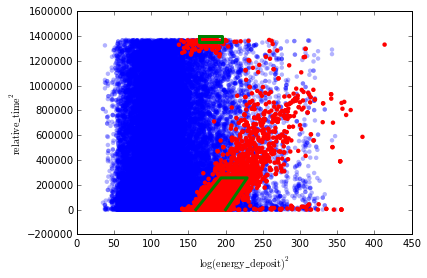

In [9]:
fig, ax = plt.subplots()
ax.scatter(np.log(noise_hits.energy_deposit)**2, noise_hits.relative_time**2, c='b', edgecolors='none', alpha=0.3)
ax.scatter(np.log(signal_hits.energy_deposit)**2, signal_hits.relative_time**2, c='r', edgecolors='none')
high_relative_time = 1.35e6
low_relative_time = 256300
low_points = np.array([[160, 0], [194, low_relative_time], [229, low_relative_time], [200, 0]])
high_points = np.array([[164, 1.4e6], [195, 1.4e6], [195, high_relative_time], [164, high_relative_time],
                        [164, 1.4e6]])
ax.plot(low_points[:, 0], low_points[:, 1], 'g', lw=3)
ax.plot(high_points[:, 0], high_points[:, 1], 'g', lw=3)
ax.set_xlabel(r"$\log(\mathrm{energy\_deposit})^2$")
ax.set_ylabel(r"$\mathrm{relative\_time}^2$")

In [10]:
top_line_coeffs = np.polyfit(low_points[0:2, 0], low_points[0:2, 1], deg=1)
bottom_line_coeffs = np.polyfit(low_points[2:4, 0], low_points[2:4, 1], deg=1)
def is_signal(event):
    log_energy_squared = np.log(event.energy_deposit)**2
    relative_time_squared = event.relative_time**2
    return (((relative_time_squared < low_relative_time) & (
            relative_time_squared < np.poly1d(top_line_coeffs)(log_energy_squared)) & (
                relative_time_squared > np.poly1d(bottom_line_coeffs)(log_energy_squared))) | 
            ((relative_time_squared > high_relative_time) & 
             (log_energy_squared > 164) & (log_energy_squared < 195)))  

Check how good the model describes the data.

In [11]:
from sklearn.metrics import roc_auc_score
hits_test_is_signal = (hits_test.label == 1)
score = roc_auc_score(hits_test_is_signal, is_signal(hits_test))
print(score)

0.877601742608


In [12]:
with open("manual_score.dat", "w") as score_io:
    score_io.write(str(score))